In [1]:
#import the necessary packages
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm
import warnings
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.inspection import permutation_importance
from bayes_opt import BayesianOptimization

In [2]:
#load the data
df = pd.read_json('ultimate_data_challenge.json')

In [3]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


# Data Cleaning

First, let's check the data type of each column. 

In [4]:
df.dtypes

city                       object
trips_in_first_30_days      int64
signup_date                object
avg_rating_of_driver      float64
avg_surge                 float64
last_trip_date             object
phone                      object
surge_pct                 float64
ultimate_black_user          bool
weekday_pct               float64
avg_dist                  float64
avg_rating_by_driver      float64
dtype: object

The columns 'sign_up date' and 'last_trip_date' should be datetime, so we'll convert them now. 

In [4]:
df['signup_date'] = pd.to_datetime(df['signup_date'])
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])

In [6]:
df.dtypes

city                              object
trips_in_first_30_days             int64
signup_date               datetime64[ns]
avg_rating_of_driver             float64
avg_surge                        float64
last_trip_date            datetime64[ns]
phone                             object
surge_pct                        float64
ultimate_black_user                 bool
weekday_pct                      float64
avg_dist                         float64
avg_rating_by_driver             float64
dtype: object

Next let's check for missing values. 

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    41878 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    49799 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

In [8]:
len(df.dropna())

41445

It looks like there are some missing values for the columns 'avg_rating_of_driver', 'phone', and 'avg_rating_by_driver'. By simply dropping NaNs, we would lose nearly a fifth of the data, so it's important to investigate each column individually to determine whether any of the rows containing missing values can be salvaged.

In [9]:
df[df['phone'].isna()]

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
134,King's Landing,0,2014-01-10,5.0,1.00,2014-06-11,None,0.0,False,100.0,2.88,5.0
176,Astapor,0,2014-01-28,5.0,1.00,2014-03-18,None,0.0,False,100.0,20.32,5.0
320,Astapor,1,2014-01-08,5.0,1.00,2014-01-09,None,0.0,False,100.0,31.01,5.0
349,Winterfell,1,2014-01-06,3.3,1.00,2014-06-22,None,0.0,True,33.3,6.03,5.0
389,King's Landing,5,2014-01-26,4.9,1.02,2014-07-01,None,3.0,False,66.7,3.08,4.8
...,...,...,...,...,...,...,...,...,...,...,...,...
49587,Winterfell,1,2014-01-17,5.0,1.00,2014-01-19,None,0.0,True,0.0,1.15,3.0
49627,Astapor,6,2014-01-05,5.0,1.00,2014-01-25,None,0.0,True,33.3,3.10,4.5
49666,Winterfell,2,2014-01-22,NaN,1.00,2014-01-23,None,0.0,True,100.0,0.73,5.0
49825,Astapor,0,2014-01-25,5.0,1.00,2014-03-10,None,0.0,True,50.0,5.82,5.0


"None" in the 'phone' column probably indicates someone without a phone, but Python treats it as an NaN. Let's change it to something more suitable like "No phone." 

In [10]:
df[df['avg_rating_of_driver'].isna()]

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
6,Astapor,1,2014-01-24,NaN,1.0,2014-01-25,Android,0.0,False,100.0,3.95,4.0
9,Winterfell,1,2014-01-03,NaN,1.0,2014-01-05,Android,0.0,False,0.0,2.37,5.0
12,Winterfell,1,2014-01-15,NaN,1.0,2014-03-12,iPhone,0.0,False,100.0,20.29,5.0
14,Astapor,1,2014-01-27,NaN,1.0,2014-01-28,Android,0.0,False,100.0,26.01,5.0
15,Winterfell,1,2014-01-15,NaN,1.0,2014-01-16,Android,0.0,True,100.0,13.20,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...
49984,Winterfell,1,2014-01-26,NaN,1.0,2014-01-26,Android,0.0,False,0.0,3.50,5.0
49985,Astapor,1,2014-01-26,NaN,1.0,2014-02-25,Android,0.0,False,100.0,1.38,5.0
49989,Winterfell,1,2014-01-24,NaN,1.0,2014-01-31,iPhone,0.0,False,100.0,0.00,5.0
49996,Astapor,1,2014-01-24,NaN,1.0,2014-01-25,iPhone,0.0,False,0.0,0.00,4.0


In [11]:
df[df['avg_rating_by_driver'].isna()]

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
90,Winterfell,1,2014-01-10,5.0,1.0,2014-02-09,iPhone,0.0,False,0.0,6.28,NaN
274,Astapor,1,2014-01-25,2.0,4.0,2014-02-09,iPhone,100.0,False,0.0,6.00,NaN
277,Winterfell,1,2014-01-25,NaN,1.0,2014-01-26,iPhone,0.0,False,0.0,1.82,NaN
536,Winterfell,1,2014-01-18,5.0,1.0,2014-02-08,Android,0.0,False,100.0,1.41,NaN
857,Winterfell,0,2014-01-11,4.0,1.0,2014-03-16,iPhone,0.0,False,0.0,0.42,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
49249,King's Landing,0,2014-01-14,5.0,1.0,2014-06-19,iPhone,0.0,True,100.0,4.60,NaN
49376,Astapor,1,2014-01-20,4.0,1.0,2014-01-24,iPhone,0.0,False,100.0,3.01,NaN
49504,Winterfell,2,2014-01-24,5.0,1.0,2014-01-25,Android,0.0,False,100.0,0.75,NaN
49599,King's Landing,1,2014-01-14,5.0,1.0,2014-02-08,iPhone,0.0,False,100.0,2.48,NaN


In the case of 'avg_rating_of_driver' and 'avg_rating_by_driver', the missing values most likely indicate that the customer either never rated their driver(s) or never received a rating from their driver(s). We can replace these missing values with the average value for each column. 

In [5]:
df.fillna({'avg_rating_of_driver': df['avg_rating_of_driver'].mean(), 
           'phone' : 'no phone', 
           'avg_rating_by_driver' : df['avg_rating_by_driver'].mean()}, inplace=True)

In [6]:
df.isna().sum()

city                      0
trips_in_first_30_days    0
signup_date               0
avg_rating_of_driver      0
avg_surge                 0
last_trip_date            0
phone                     0
surge_pct                 0
ultimate_black_user       0
weekday_pct               0
avg_dist                  0
avg_rating_by_driver      0
dtype: int64

Next we need to reate a column indicating whether or not each customer was retained (i.e., whether they use the app in the month of June). Performing a value count on this column shows that 37.6% of users were retained. 

In [7]:
df['retained'] = df['last_trip_date'] >= dt.datetime(2014, 6, 1)
df.drop(columns=['last_trip_date', 'signup_date'], inplace=True)

In [8]:
df['retained'].value_counts(normalize=True)

False    0.62392
True     0.37608
Name: retained, dtype: float64

Finally, we should check whether any of the columns are correlated by plotting a heatmap of the correlation matrix. 

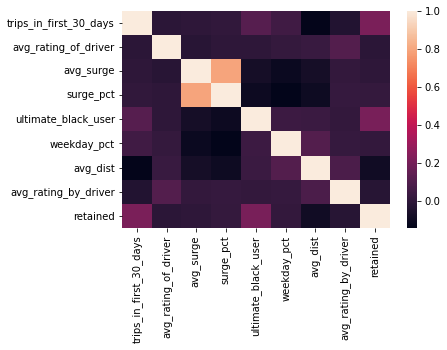

In [9]:
sns.heatmap(df.corr())
plt.show();

Unsurprisingly, 'avg_surge' and 'surge_pct' are highly correlated, so we can safely exclude one of these columns from the analysis. 

In [10]:
df.drop(columns='avg_surge', inplace=True)

# Exploratory Data Analysis

We'll start exploratory data analysis by graphing the categorical variables to see whether there is any difference in retention rates between various demographic groups (e.g., inhabitants of different cities). 

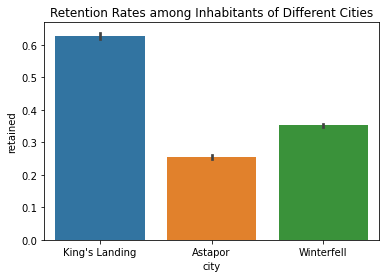

In [11]:
sns.barplot(x='city', y='retained', data=df)
plt.title("Retention Rates among Inhabitants of Different Cities")
plt.show();

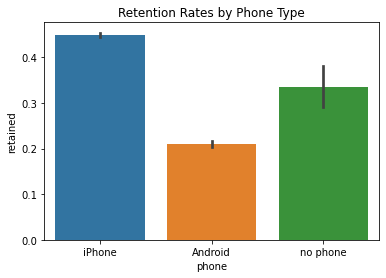

In [13]:
sns.barplot(x='phone', y='retained', data=df)
plt.title("Retention Rates by Phone Type")
plt.show();

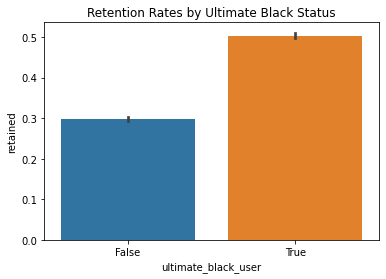

In [12]:
sns.barplot(x='ultimate_black_user', y='retained', data=df)
plt.title("Retention Rates by Ultimate Black Status")
plt.show();

It looks like there are differences in retention rates for each of the three demographic categories; we should retain these variables for the modeling stage. Next let's check there is a difference between retained and non-retained customers for each numerical category. 

In [14]:
df_retained = df[df['retained'] == True].drop(columns = ['city', 'phone', 'ultimate_black_user'])
df_left = df[df['retained'] == False].drop(columns = ['city', 'phone', 'ultimate_black_user'])

In [15]:
df_retained.describe()

,trips_in_first_30_days,avg_rating_of_driver,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,18804.000000,18804.000000,18804.000000,18804.000000,18804.000000,18804.000000
mean,3.306318,4.593679,9.152797,61.389034,5.114788,4.762801
std,4.986743,0.518319,15.588704,29.487584,4.615175,0.328175
min,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.400000,0.000000,44.400000,2.560000,4.700000
50%,2.000000,4.700000,0.000000,64.300000,3.730000,4.800000
75%,4.000000,5.000000,13.300000,84.600000,5.890000,5.000000
max,125.000000,5.000000,100.000000,100.000000,160.960000,5.000000


In [16]:
df_left.describe()

,trips_in_first_30_days,avg_rating_of_driver,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,31196.000000,31196.000000,31196.000000,31196.000000,31196.000000,31196.000000
mean,1.658482,4.606309,8.666739,60.647032,6.207939,4.787415
std,2.654222,0.591282,22.179139,40.982688,6.238675,0.503312
min,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.500000,0.000000,16.700000,2.320000,4.800000
50%,1.000000,4.800000,0.000000,69.600000,4.030000,5.000000
75%,2.000000,5.000000,0.000000,100.000000,7.800000,5.000000
max,73.000000,5.000000,100.000000,100.000000,129.890000,5.000000


In [17]:
difference = df_retained.describe() - df_left.describe()

difference.loc['mean']

trips_in_first_30_days    1.647836
avg_rating_of_driver     -0.012630
surge_pct                 0.486058
weekday_pct               0.742003
avg_dist                 -1.093150
avg_rating_by_driver     -0.024614
Name: mean, dtype: float64

There is a difference between the two groups for each numerical category, but it's hard to tell whether these differences are statistically significant. To check whether this is the case, I defined a helper function that calculates bootstrap samples of the difference in mean values between retained and left for a given column, plots a histogram of the bootstraps along with the observed difference, and returns the p-value of the observed value. This function will help me preform hypothesis tests on each of the variables under consideration. In every case, the null hypothesis is that there is no difference in the mean values between retained and left; the alternative hypothesis is that there is a difference.   

In [18]:
def graph_bootstraps(col, n):
    diffs = np.empty(n)
    for i in range(n):
        df_new = df.drop(columns=col)
        df_new[col] = df[col].sample(n=50000, replace=True).reset_index(drop=True)
        diffs[i] = df_new[df_new['retained'] == True][col].mean() - df_new[df_new['retained'] == False][col].mean()
        observed = df_retained['trips_in_first_30_days'].mean() - df_left['trips_in_first_30_days'].mean()
    observed = df_retained[col].mean() - df_left[col].mean()
    p = len(diffs[diffs >= observed])/len(diffs)
    plt.hist(diffs)
    plt.vlines(x=observed, ymin=0, ymax=3000, color='red', linestyle='--', label=f"p = {p}")
    plt.xlabel(f"Differences in the average of {col} between retained and non-retained customers")
    plt.legend()
    plt.show();

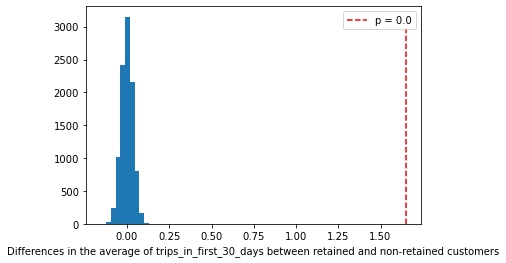

In [19]:
graph_bootstraps('trips_in_first_30_days', 10000)

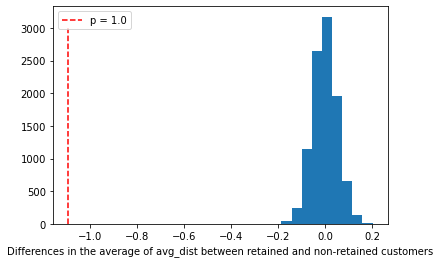

In [20]:
graph_bootstraps('avg_dist', 10000)

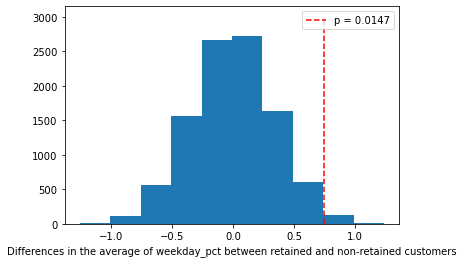

In [21]:
graph_bootstraps('weekday_pct', 10000)

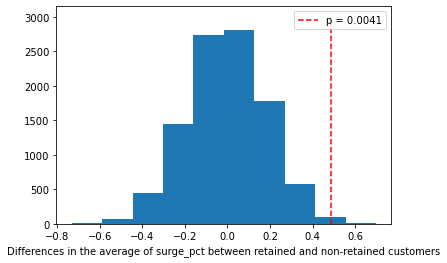

In [22]:
graph_bootstraps('surge_pct', 10000)

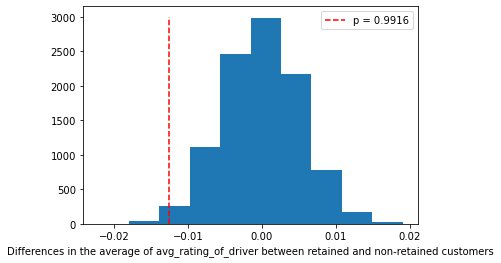

In [23]:
graph_bootstraps('avg_rating_of_driver', 10000) 

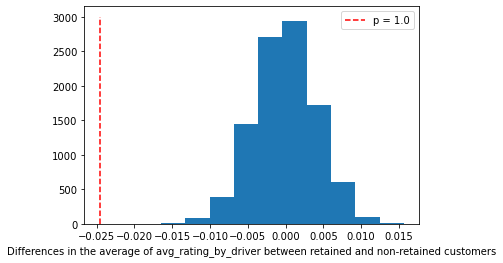

In [24]:
graph_bootstraps('avg_rating_by_driver', 10000) 

We can reject the null hypothesis in the case of 'trips_in_first_30_days', 'avg_dist', 'weekday_pct', 'surge_pct', 'avg_rating_of_driver', and 'avg_rating_by_driver' with a p-value of < .0001, < .0001, .0126, .0037, .0081, and < .0001 respectively. This means that the difference in average value between the two groups is statistically significant for all of the numerical variables. Accordingly, we should retain these variables in the modeling stage. 

# Modeling

We'll start the modeling process by encoding the categorical variables and dividing the data in train and test sets. 

In [27]:
df_dummies = pd.get_dummies(df, drop_first=True)
df_dummies.replace({True : 1, False : 0}, inplace=True)

In [28]:
df_dummies.head()

,trips_in_first_30_days,avg_rating_of_driver,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained,city_King's Landing,city_Winterfell,phone_iPhone,phone_no phone
0,4,4.7,15.4,1,46.2,3.67,5.0,1,1,0,1,0
1,0,5.0,0.0,0,50.0,8.26,5.0,0,0,0,0,0
2,3,4.3,0.0,0,100.0,0.77,5.0,0,0,0,1,0
3,9,4.6,20.0,1,80.0,2.36,4.9,1,1,0,1,0
4,14,4.4,11.8,0,82.4,3.13,4.9,0,0,1,0,0


In [29]:
X = df_dummies.drop(columns='retained')
y = df_dummies[['retained']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

Because the data contain a mix of categorical and numeric variables, a tree-based classifier is well suited to the problem. Here I've opted for a random forest classifier due to its greater predictive power compared to individual decision trees; other possiblibilities to try in the future include Ada Boosting or Gradient Boosting. I will tune the model using Bayesian Optimization since it is more computationally efficient than either Grid Search or Random Search. I've chosen the f1-score as the scoring metric because we would like for the model to identify as many potentially loyal customers as possible (i.e., have high recall) without making many mistakes (i.e., have high precision). As the harmonic mean of precision and recall, the f1 score takes both of these metrics into account. 

In [35]:
warnings.filterwarnings("ignore")

def rf_eval(n_estimators, max_depth, max_features):
    
    params = {'n_estimators' : int(n_estimators), 
              'max_depth' : int(max_depth), 
              'max_features' : int(max_features)}
    scores = cross_val_score(RandomForestClassifier(**params), 
                             X_train, 
                             y_train, 
                             scoring='f1', 
                             cv=5)
    score = scores.mean()
    
    return score

rf_BO = BayesianOptimization(rf_eval, {'n_estimators' : (200, 2000), 
                                       'max_depth' : (1, 100) , 
                                       'max_features' : (1, 5)})

rf_BO.maximize(n_iter=10, init_points=2)



|   iter    |  target   | max_depth | max_fe... | n_esti... |
-------------------------------------------------------------
|  1        |  0.6751   |  25.41    |  1.396    |  822.8    |
|  2        |  0.6764   |  64.26    |  2.287    |  1.608e+0 |
|  3        |  0.6745   |  65.1     |  1.942    |  1.612e+0 |
|  4        |  0.6756   |  62.11    |  3.928    |  619.7    |
|  5        |  0.6768   |  97.26    |  3.458    |  813.4    |
|  6        |  0.6752   |  5.573    |  4.93     |  1.355e+0 |
|  7        |  0.6762   |  62.85    |  2.747    |  1.61e+03 |
|  8        |  0.6759   |  65.73    |  2.641    |  1.606e+0 |
|  9        |  0.6764   |  96.23    |  3.688    |  813.7    |
|  10       |  0.6741   |  98.29    |  1.227    |  816.2    |
|  11       |  0.6762   |  61.35    |  2.081    |  1.61e+03 |
|  12       |  0.6746   |  61.57    |  1.391    |  1.607e+0 |


The best random forest model had a max_depth of 97, max_features of 3, and 813 estimators and achieved an f1 score of .6768 on the training set. Let's see how it performs on the test set.  

In [36]:
best_params = rf_BO.max

In [37]:
rf = RandomForestClassifier(n_estimators = int(best_params['params']['n_estimators']),
                            max_depth = int(best_params['params']['max_depth']),
                            max_features = int(best_params['params']['max_features']))

rf.fit(X_train, y_train)
 
y_pred = rf.predict(X_test)

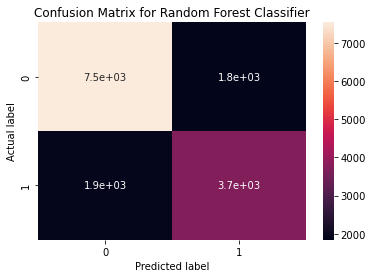

In [42]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
plt.title('Confusion Matrix for Random Forest Classifier')
plt.show();

The model's performance on the test set looks pretty good at this point (f1 = ~.67), although it could always be improved by additional rounds of Bayesian Optimization. As a final step in the analysis, we'll look at the importance of the various features for predicting retention. 

In [45]:
result = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42)

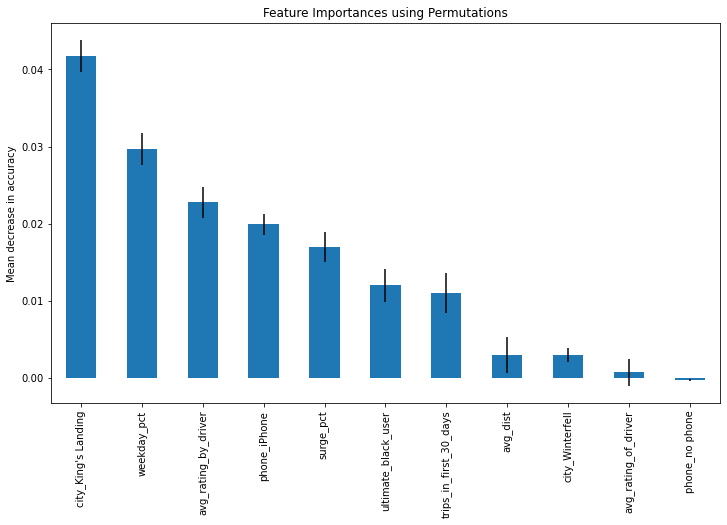

In [57]:
rf_importances = pd.Series(result.importances_mean, index=X.columns).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(12, 7))
rf_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature Importances using Permutations")
ax.set_ylabel("Mean decrease in accuracy")
plt.plot();

The seven most important features of the model are location, percentage of weekday travel, average rating by driver, type of phone, surge percentage, Ultimate Black status, and the number of trips in the first 30 days. These results suggest five directions for further investigation. 

First, inhabitants of King's Landing were more likely to remain customers than their counterparts in Winterfell and Astapor (~62% vs ~35% and ~25% respectively). But what's driving this difference? Are there fewer drivers in Winterfell and Astapor, making it more difficult for customers to find a ride? Or are the drivers in these cities particularly rude, turning people off of the service? 

Second, iPhone users were more than twice as likely as Android owners to continue using Ultimate after six months (~45% vs ~21%). This discrepancy could indicate that the Android version of the Ultimate app is difficult to use. 

Third, average rating by driver played an important role in retention, with lower rated customers desisting more often than their more highly rated counterparts. Perhaps these riders felt slighted by a low rating and gave up on the service. If that's the case, it might make sense to remove the ability of drivers to rate their riders.    

Fourth, loyal customers tended to travel slightly less often on weekdays and during surge periods. These differences could indicate that Ultimate's surge pricing model is a little too aggressive and is driving away customers who rely on ride shares during the week.  

Fifth, the role of Ultimate Black status and the number of trips in the first 30 days represents something of a chicken and egg problem. Do customers sign up for Ultimate Black because they intend to remain customers (i.e., buy-in) or do they remain customers because they signed up for Ultimate Black (i.e., sunk cost fallacy)? Similarly, do users take a lot of trips in the first 30 days because they enjoy the service and intend to keep it, or do they become habituated to Ultimate by frequent use? If the latter is true in either case, we could encourage users to sign up for Ultimate Black and/or take more trips in their first 30 days by offering an initial discount.  